#### __10. 케라스를 사용한 인공 신경망 소개__

__10.1 퍼셉트론__

In [1]:
import os
import sys
 
import sklearn
import tensorflow as tf

import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# 퍼셉트론 학습 알고리즘
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()

X = iris.data[:, (2, 3)]
y = (iris.target == 0).astype(np.int64)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1], dtype=int64)

In [2]:
# 케라스를 사용하여 데이터 적재
keras = tf.keras
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [18]:
X_train_full.shape, X_train_full.dtype

((60000, 28, 28), dtype('uint8'))

In [19]:
# 전체 훈련 세트를 검증세트와 훈련 세트로 구분하고,
# 픽셀 강도를 255로 나누어 0~1 범위의 실수로 변환
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

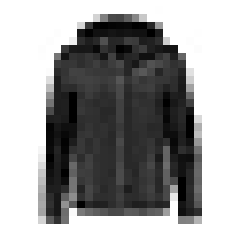

In [20]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

In [21]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [22]:
# 클래스 이름 정의
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [23]:
class_names[y_train[0]]

'Coat'

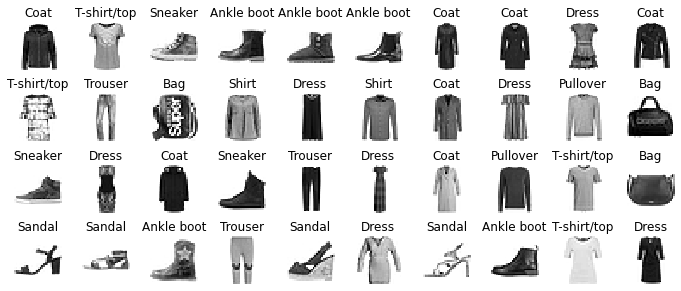

In [24]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [27]:
# 두 개의 은닉층으로 이루어진 분류용 다층 퍼셉트론
# 케라스의 신경망 모델, 순서대로 연결된 층을 일렬로 쌓아서 구성(Sequential API라고 함)
model = keras.models.Sequential()
# Flatten 층은 이미지를 1D 배열로 변환 X.reshape(-1, 28*28)을 계산, 모델 파라미터를 갖지 않고 전처리만 수행
# input_shape를 지정해야 하는데, 배치 크기는 제외하고 샘플의 크기만 작성
model.add(keras.layers.Flatten(input_shape=[28, 28]))
# 뉴런 n개를 가진 은닉층을 추가, 각 Dense층마다 각자의 가중치 행렬을 관리
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [39]:
keras.backend.clear_session()  # 모델 번호 초기화할 수 있음
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
# Sequential 모델을 만들 때 층의 리스트를 전달할 수도 있음
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


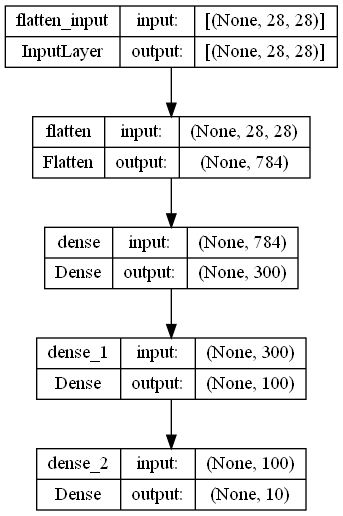

In [46]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [41]:
model.layers

In [43]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [45]:
model.get_layer("dense") is hidden1

True

In [47]:
weights, biases = hidden1.get_weights()

In [48]:
weights

array([[ 0.05573048, -0.05177023,  0.0632301 , ..., -0.04606758,
        -0.0429829 ,  0.05034173],
       [ 0.01207785, -0.04817232, -0.00353475, ...,  0.05494893,
        -0.00443948,  0.02563734],
       [ 0.02798492, -0.0087443 , -0.06265406, ..., -0.00828946,
         0.0088362 , -0.00614267],
       ...,
       [-0.01629935,  0.07088424,  0.0210902 , ...,  0.02845319,
         0.04653872, -0.01588505],
       [ 0.07364814,  0.02355933,  0.07433105, ...,  0.05494453,
         0.04491815, -0.0069415 ],
       [ 0.06881817, -0.06710415, -0.00482001, ...,  0.0723791 ,
         0.04813275, -0.01996209]], dtype=float32)

In [56]:
weights.shape

(784, 300)

In [52]:
biases.shape

(300,)

In [59]:
# 모델 컴파일
# 사용할 손실 함수와 옵티마이저를 지정, 부가적으로 훈련과 평가 시 계산할 지표를 추가로 지정할 수 있다
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [75]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1460 - accuracy: 0.9495 - val_loss: 0.2964 - val_accuracy: 0.8964
Epoch 2/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1455 - accuracy: 0.9492 - val_loss: 0.2959 - val_accuracy: 0.8974
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1461 - accuracy: 0.9491 - val_loss: 0.4128 - val_accuracy: 0.8684
Epoch 4/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1446 - accuracy: 0.9488 - val_loss: 0.3083 - val_accuracy: 0.8990
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1436 - accuracy: 0.9483 - val_loss: 0.2902 - val_accuracy: 0.9000
Epoch 6/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1399 - accuracy: 0.9509 - val_loss: 0.3224 - val_accuracy: 0.8936
Epoch 7/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1383 - accuracy: 0.9507 - val_loss: 0.3068 - val_accuracy:

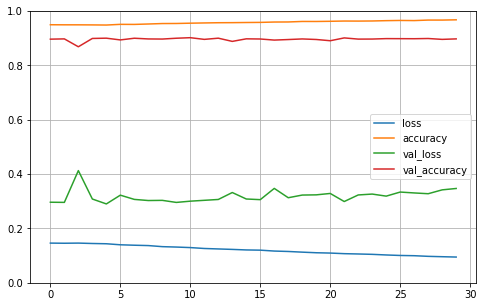

In [76]:
# 학습곡선
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [77]:
# 일반화 오차 추정
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3851 - accuracy: 0.8908


[0.3851008415222168, 0.8907999992370605]

In [79]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 67ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [81]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 16ms/step


array([9, 2, 1], dtype=int64)

In [83]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [84]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

In [8]:
# 시퀀셜 API를 사용하여 회귀용 다층 퍼셉트론 만들기
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

np.random.seed(42)
tf.random.set_seed(42)

In [13]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]  # 새로운 샘플이라고 가정
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 2.2956 - val_loss: 1.3542
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.9022 - val_loss: 0.9485
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7204 - val_loss: 0.7087
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6600 - val_loss: 0.6007
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6234 - val_loss: 0.5762
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5929 - val_loss: 0.5520
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5680 - val_loss: 0.5232
Epoch 8/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5458 - val_loss: 0.5153
Epoch 9/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5259 - val_loss: 0.4933
Epoch 10/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5086 - val_loss: 0.4803

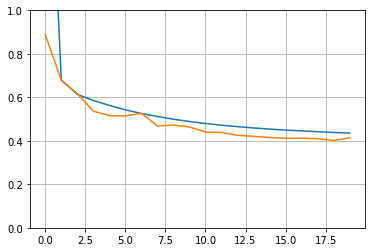

In [14]:
import pandas as pd

plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [16]:
# 함수형 API
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 30)           270         ['input_2[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 30)           930         ['dense_7[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 38)           0           ['input_2[0][0]',                
                                                                  'dense_8[0][0]']            

In [20]:
# 와이드나 딥 경로에 다른 입력 특성을 전달
# 특성 0~4의 5개의 특성을 와이드 경로에 보내고, 특성 2~7의 6개의 특성을 딥 경로에 전달, 특성 2~4의 3개는 양쪽 모두 전달
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 deep_input (InputLayer)        [(None, 6)]          0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 30)           210         ['deep_input[0][0]']             
                                                                                                  
 wide_input (InputLayer)        [(None, 5)]          0           []                               
                                                                                                  
 dense_13 (Dense)               (None, 30)           930         ['dense_12[0][0]']               
                                                                                            

In [22]:
# 입력마다 하나씩 행렬의 튜플을 전달해 컴파일한다
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 0.4288 - val_loss: 0.4036
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4260 - val_loss: 0.4232
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4243 - val_loss: 0.3974
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4218 - val_loss: 0.3958
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4203 - val_loss: 0.3948
Epoch 6/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4179 - val_loss: 0.4016
Epoch 7/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4167 - val_loss: 0.3895
Epoch 8/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4152 - val_loss: 0.3979
Epoch 9/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4132 - val_loss: 0.3917
Epoch 10/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4119 - val_loss: 0.3879

In [23]:
# 보조 출력 추가하기
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 deep_input (InputLayer)        [(None, 6)]          0           []                               
                                                                                                  
 dense_14 (Dense)               (None, 30)           210         ['deep_input[0][0]']             
                                                                                                  
 wide_input (InputLayer)        [(None, 5)]          0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 30)           930         ['dense_14[0][0]']               
                                                                                            

In [24]:
# 각 출력은 자신만의 손실 함수가 필요하므로, 컴파일 시 손실의 리스트를 전달해야 한다
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [25]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 3s 6ms/step - loss: 2.2885 - main_output_loss: 2.1620 - aux_output_loss: 3.4267 - val_loss: 1.9117 - val_main_output_loss: 1.8070 - val_aux_output_loss: 2.8541
Epoch 2/20
363/363 [==============================] - 2s 6ms/step - loss: 0.9271 - main_output_loss: 0.8052 - aux_output_loss: 2.0244 - val_loss: 0.9279 - val_main_output_loss: 0.7678 - val_aux_output_loss: 2.3688
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.7791 - main_output_loss: 0.6921 - aux_output_loss: 1.5621 - val_loss: 0.7685 - val_main_output_loss: 0.6242 - val_aux_output_loss: 2.0672
Epoch 4/20
363/363 [==============================] - 2s 6ms/step - loss: 0.7006 - main_output_loss: 0.6251 - aux_output_loss: 1.3803 - val_loss: 0.7025 - val_main_output_loss: 0.5741 - val_aux_output_loss: 1.8580
Epoch 5/20
363/363 [==============================] - 2s 6ms/step - loss: 0.6526 - main_output_loss: 0.5811 - aux_output_loss: 1.2958 - val_loss

In [27]:
# 손실은 개별 손실과 총 손실을 함께 반환한다
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 1s 3ms/step - loss: 0.4700 - main_output_loss: 0.4217 - aux_output_loss: 0.9043


In [29]:
# 예측도 마찬가지로 각 출력에 대한 예측을 반환한다
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])
y_pred_main, y_pred_aux

1/1 [==============================] - 0s 18ms/step


(array([[0.4268167],
        [1.9086319],
        [3.3173814]], dtype=float32),
 array([[0.989543 ],
        [1.8324565],
        [2.4352393]], dtype=float32))

In [34]:
# 서브클래싱 API로 동적 모델 만들기
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # 표준 매개변수를 처리(예를 들면, name)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
    
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden(input_B)
        hidden2 = self.hidden(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [37]:
# 저장과 복원
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 1.9849 - val_loss: 2.7383
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.7335 - val_loss: 1.1457
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6378 - val_loss: 0.7099
Epoch 4/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5880 - val_loss: 0.6674
Epoch 5/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5509 - val_loss: 0.5425
Epoch 6/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5187 - val_loss: 0.5231
Epoch 7/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4932 - val_loss: 0.4746
Epoch 8/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4724 - val_loss: 0.4518
Epoch 9/10
363/363 [==============================] - 1s 4ms/step - loss: 0.4561 - val_loss: 0.4392
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.4272


In [38]:
model.save("my_keras_model.h5")

In [40]:
model = keras.models.load_model("my_keras_model.h5")

In [41]:
# 콜백 사용하기
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
# ModelCheckpoint는 훈련하는 동안 일정 간격으로 모델의 체크포인트 저장(매 에포크 끝에서 호출)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # 최상의 모델로 롤백
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 2s 4ms/step - loss: 2.0543 - val_loss: 1.1861
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.7825 - val_loss: 0.7021
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6931 - val_loss: 0.6794
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6529 - val_loss: 0.6181
Epoch 5/10
363/363 [==============================] - 1s 4ms/step - loss: 0.6203 - val_loss: 0.5806
Epoch 6/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5901 - val_loss: 0.5650
Epoch 7/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5647 - val_loss: 0.5686
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5418 - val_loss: 0.5092
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5202 - val_loss: 0.4964
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.5061


In [43]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])  # 조기종료 구현
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3613 - val_loss: 0.3445
Epoch 2/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3601 - val_loss: 0.3730
Epoch 3/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3590 - val_loss: 0.3588
Epoch 4/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3578 - val_loss: 0.3443
Epoch 5/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3567 - val_loss: 0.3440
Epoch 6/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3556 - val_loss: 0.3479
Epoch 7/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3547 - val_loss: 0.3370
Epoch 8/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3538 - val_loss: 0.3376
Epoch 9/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3528 - val_loss: 0.3452
Epoch 10/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3519 - val_lo

In [45]:
# 사용자 정의 콜백
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(f'\nval/train: {logs["val_loss"] / logs["loss"]:.2f}')

In [46]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

344/363 [===========================>..] - ETA: 0s - loss: 0.3170
val/train: 0.97
363/363 [==============================] - 1s 3ms/step - loss: 0.3198 - val_loss: 0.3114


In [47]:
# 텐서보드
import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2023_02_12-03_44_26'

In [48]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [50]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [52]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 2s 4ms/step - loss: 1.9170 - val_loss: 1.2427
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 0.8539 - val_loss: 0.7598
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.7261 - val_loss: 0.6840
Epoch 4/30
363/363 [==============================] - 1s 4ms/step - loss: 0.6723 - val_loss: 0.6277
Epoch 5/30
363/363 [==============================] - 1s 4ms/step - loss: 0.6336 - val_loss: 0.5867
Epoch 6/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5998 - val_loss: 0.5593
Epoch 7/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5720 - val_loss: 0.5286
Epoch 8/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5471 - val_loss: 0.5089
Epoch 9/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5253 - val_loss: 0.4897
Epoch 10/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5067 - val_loss: 0.4705

In [53]:
!tensorboard --logdir=./my_logs --port=6006

^C


In [58]:
# 주피터 안에서 텐서보드 사용
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 40852), started 0:03:26 ago. (Use '!kill 40852' to kill it.)

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.10.1 at http://localhost:6006/ (Press CTRL+C to quit)


In [4]:
# 하이퍼파라미터 튜닝
np.random.seed(42)
tf.random.set_seed(42)

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [7]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\Kang MinJae\AppData\Local\Temp\ipykernel_13600\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [10]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 3s 3ms/step - loss: 1.2074 - val_loss: 11.0243
Epoch 2/100
363/363 [==============================] - 1s 3ms/step - loss: 0.7381 - val_loss: 4.2183
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5748 - val_loss: 0.6058
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5051 - val_loss: 0.4902
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4714 - val_loss: 0.4592
Epoch 6/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4489 - val_loss: 0.4545
Epoch 7/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4358 - val_loss: 0.4174
Epoch 8/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4266 - val_loss: 0.4006
Epoch 9/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4189 - val_loss: 0.4217
Epoch 10/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4131 - val_l

In [15]:
y_pred = keras_reg.predict(X_new)
y_pred

1/1 [==============================] - 0s 18ms/step


array([0.46923047, 1.7781029 , 4.303201  ], dtype=float32)

In [16]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 1s 4ms/step - loss: 0.8314 - val_loss: 0.4948
Epoch 2/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4909 - val_loss: 0.4222
Epoch 3/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4512 - val_loss: 0.4021
Epoch 4/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4371 - val_loss: 0.3882
Epoch 5/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4275 - val_loss: 0.3877
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4218 - val_loss: 0.3881
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4369 - val_loss: 0.3821
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4252 - val_loss: 0.3827
Epoch 9/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4124 - val_loss: 0.3796
Epoch 10/100
242/242 [========

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001DAD31EB2E0>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.007821074275112...
                                                          0.005021425736625637,
                                                          0.0005703073595961105,
                                                          0.001151888789941251,
                                                          0.001621231156394198,
                                                          0.0024505367684280487,
                                                          0.011155092541719619,
                                                          0.0007524347058135697,
                                                          0.0032032448128444043,
                                                          0.004591455636549438,
                                                          0.0003715541189658278, ...],
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...]},
                   verbose=2)

In [17]:
rnd_search_cv.best_params_

{'n_neurons': 80, 'n_hidden': 3, 'learning_rate': 0.0059640580092043885}

In [18]:
rnd_search_cv.best_score_

-0.32021965583165485

In [19]:
rnd_search_cv.best_estimator_

In [20]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3203


-0.32031285762786865